In [23]:
import matplotlib.pyplot as plt
import numpy as np
import gcs 
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import coordinates as coord

In [39]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [25]:
refframe={
    "vLSR": [0, 240, 0],
    "vSun": [11.1, 12.24, 7.25],
    "galcen_distance": 8340,
    "z_sun": 27,
    "unit":{
        "vLSR": u.km/u.s,
        "vSun": u.km/u.s,
        "galcen_distance": u.pc,
        "z_sun": u.pc
    }
}

vSun = refframe['vSun']*u.Unit(refframe['unit']["vSun"])
vLSR = refframe['vLSR']*u.Unit(refframe['unit']["vLSR"])
galcen_distance=refframe['galcen_distance']*u.Unit(refframe['unit']['galcen_distance'])
z_sun=refframe['z_sun']*u.Unit(refframe['unit']['z_sun'])   
refferenceframe=coord.Galactocentric(galcen_distance = galcen_distance,galcen_v_sun=vLSR+vSun,z_sun=z_sun)

In [71]:
## Set the global variables
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"
MWpotential="pouliasis2017pii-GCNBody"

outname = "stream_on_sky_{:s}_{:s}_{:s}.png".format(GCname,montecarlokey,MWpotential)

In [34]:
# load the position of the globular cluster on the sky
pathInitialConditions=gcs.path_handler.MonteCarloObservables(GCname)
Mass,Size,RA,DEC,Rsun,RV,mu_delta,mualpha=gcs.extractors.MonteCarloObservables.extract_GC_observables(pathInitialConditions,montecarlokey)
my_sky=SkyCoord(ra=RA, dec=DEC, distance=Rsun, pm_ra_cosdec=mualpha, pm_dec=mu_delta, radial_velocity=RV).transform_to("galactic")
my_sky.l.wrap_angle=180*u.deg

In [17]:
# load the stream
streampath=gcs.path_handler.old_streams(MWpotential=MWpotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP,)
_,xp,yp,zp,vxp,vyp,vzp=gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP,)

In [35]:
# put the stream on the sky 
mySkyCoords = SkyCoord(
    x=xp*u.kpc, y=yp*u.kpc, z=zp*u.kpc, 
    v_x=vxp*u.km/u.s, v_y=vyp*u.km/u.s, v_z=vzp*u.km/u.s, 
    frame=refferenceframe, representation_type='cartesian')
galacticCoords=mySkyCoords.transform_to("galactic")

In [36]:
# filter the stream to only get a region we want
myL=galacticCoords.l.wrap_at(180*u.deg).degree - my_sky.l.value
myB=galacticCoords.b.degree-my_sky.b.value

bottomFilter = myB > -50
topFilter = myB < 10

leftFilter = myL > -50
rightFilter = myL < 35

streamFilter = bottomFilter & topFilter & leftFilter & rightFilter

myL=myL[streamFilter]
myB=myB[streamFilter]

In [67]:
nBins=int(np.ceil(np.sqrt(myL.shape[0])))
counts,edges = np.histogram(myL, bins=nBins)
normalized_counts = counts / NP

# Prepare data for step plot
x = np.repeat(edges, 2)[1:-1]
y = np.repeat(normalized_counts, 2)


In [45]:
print(my_sky.l.to(u.deg).wrap_at(180*u.deg).degree,my_sky.b.to(u.deg).degree)

0.8389120226728517 45.8558725192418


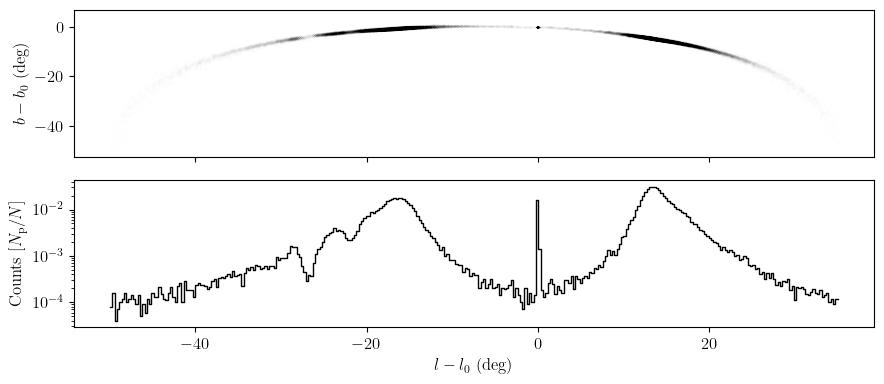

In [73]:
fig, axis = plt.subplots(2, 1, figsize=(9, 4),sharex=True)
axis[0].scatter(myL, myB, s=0.01, c="k", alpha=0.05)
axis[1].plot(x, y, color='k',linewidth=1)  # Plot the outline of the histogram
axis[1].set_yscale('log')
axis[1].set_xlabel(r'$l-l_0$ (deg)')
axis[0].set_ylabel(r'$b-b_0$ (deg)')
axis[1].set_ylabel('Counts [$N_{\mathrm{p}}/N$]')
# axis[0].text(-40,-25,r"($l_0,b_0$)=(%.2f$^{\circ}$,%.2f$^{\circ}$)"%(my_sky.l.to(u.deg).wrap_at(180*u.deg).degree,my_sky.b.to(u.deg).degree),fontsize=12)

fig.tight_layout()
fig.savefig("../paper/"+outname, dpi=300)